Define the distance between two gates $V_1$ and $V_2$ as follows:
$$d(V_1,V_2) = \int_{\mathcal{H}}\left| \langle \psi |V_2^\dagger V_1|\psi\rangle \right|^2 d\mu(\psi)$$
where the measure is Haar measure, i.e. the quantum state is sampled uniformly at random in the Hilbert space.

In [189]:
import qiskit
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity, Clifford, random_clifford
from qiskit import QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [123]:
def approx_gates_distance(num_samples, oper_1, oper_2, d_measure):
    V1, args1 = oper_1
    V2, args2 = oper_2
    
    distance = []
    
    for i in range(num_samples):
        
        vec = random_statevector(2) # sample random state by Haar measure
        #print('before circuit: {}'.format(vec)) 

        qc_1 = QuantumCircuit(1)
        getattr(qc_1, V1)(*args1)
        #print(qc_1.draw())
        new_vec_1 = vec.evolve(qc_1)
        #print('after circuit 1: {}'.format(new_vec_1))

        qc_2 = QuantumCircuit(1)
        getattr(qc_2, V2)(*args2)
        #print(qc_2.draw())
        new_vec_2 = vec.evolve(qc_2)
        #print('after circuit 2: {}'.format(new_vec_2))

        fidelity = min(state_fidelity(new_vec_1, new_vec_2), 1.) # avoid numerical problem
        
        if d_measure == 'bures':
            distance.append(1 - fidelity)
        if d_measure == 'f-s': #fubini-study metric
            distance.append(np.arccos(fidelity**(1/2)))
    
    return np.mean(distance)

In [142]:
print(approx_gates_distance(1000, ('x',(0,)), ('y',(0,)), 'bures'))
print(approx_gates_distance(1000, ('x',(0,)), ('h',(0,)), 'bures'))
print(approx_gates_distance(1000, ('z',(0,)), ('t',(0,)), 'bures'))
print(approx_gates_distance(1000, ('x',(0,)), ('x',(0,)), 'bures'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(approx_gates_distance(100, ('rx',[theta,0]), ('y',(0,)), 'bures'))
print("rx-y", np.mean(dist))

0.6541207277564909
0.33541500278090847
0.5547179895714036
9.992007221626409e-17
rx-y 0.6650916815901142


In [141]:
print(approx_gates_distance(1000, ('x',(0,)), ('y',(0,)), 'f-s'))
print(approx_gates_distance(1000, ('x',(0,)), ('h',(0,)), 'f-s'))
print(approx_gates_distance(1000, ('z',(0,)), ('t',(0,)), 'f-s'))
print(approx_gates_distance(1000, ('x',(0,)), ('x',(0,)), 'f-s'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(approx_gates_distance(100, ('rx',[theta,0]), ('y',(0,)), 'f-s'))
print("rx-y ", np.mean(dist))

0.9953775606406641
0.598090536211261
0.8503824528639954
5.04870611615276e-09
rx-y  1.00182776834135


We can write $|\psi\rangle = U|0\rangle$, where $U$ is a random unitary operator sampled according to Haar measure. Moreover, a unitary 2-design $\{U_j\}_{j=1}^k$ would satisfy
$$\frac{1}{K} \sum_{j=1}^K \left| \langle 0| U_j^\dagger V_2^\dagger V_1 U_j|0\rangle \right|^2 
= \int_{\mathcal{U}}\left| \langle 0| U^\dagger V_2^\dagger V_1 U|0\rangle \right|^2 d\mu(U)$$

There is one beautiful result saying that Clifford group (normalizers of Pauli group) constitute a unitary 3-design, thus also a unitary 2-design. For one-qubit, the Clifford group contains 24 elements, each a product of Hadamard gate and S gate. This allows us to compute exactly the average fidelity in a very efficient manner.

In [75]:
single_qubit_cliffords = [
 'i',
 'h', 's',
 'hs', 'sh', 'ss',
 'hsh', 'hss', 'shs', 'ssh', 'sss',
 'hshs', 'hssh', 'hsss', 'shss', 'sshs',
 'hshss', 'hsshs', 'shssh', 'shsss', 'sshss',
 'hshssh', 'hshsss', 'hsshss'
]

# single_qubit_cliffords = [
#  'I',
#  'H', 'S',
#  'HS', 'SH', 'SS',
#  'HSH', 'HSS', 'SHS', 'SSH', 'SSS',
#  'HSHS', 'HSSH', 'HSSS', 'SHSS', 'SSHS',
#  'HSHSS', 'HSSHS', 'SHSSH', 'SHSSS', 'SSHSS',
#  'HSHSSH', 'HSHSSS', 'HSSHSS'
# ]

In [125]:
def apply_clifford_from_string(qc, clifford_string):
    for gate in clifford_string:
        #instr = (gate, qubit)
        #getattr(qc, instr[0])(instr[1])
        getattr(qc, gate)(qc.qubits)
    return qc
        
def apply_clifford(qc, clifford):

    if isinstance(clifford, str):
        apply_clifford_from_string(qc, clifford)
        
    else:
        cliff_circ = clifford.to_circuit()
        qc = qc.compose(cliff_circ)
    #print(qc.draw())
    return qc
        
        
def compute_gates_distance_clifford(num_qubits, oper_1, oper_2, cliffords, d_measure):
    
    V1, args1 = oper_1
    V2, args2 = oper_2
    
    clifford_distance = []
    
    for i in range(len(cliffords)):
        clifford_string = cliffords[i]
        #print(clifford_string)
        
        vec = Statevector.from_label('0'*num_qubits) # |0\rangle

        qc_1 = QuantumCircuit(num_qubits)
        qc_1 = apply_clifford(qc_1, clifford_string)
        getattr(qc_1, V1)(*args1)
        new_vec_1 = vec.evolve(qc_1)
        
        qc_2 = QuantumCircuit(num_qubits)
        qc_2 = apply_clifford(qc_2, clifford_string)
        getattr(qc_2, V2)(*args2)
        new_vec_2 = vec.evolve(qc_2)
        
        
        fidelity = min(state_fidelity(new_vec_1, new_vec_2), 1.)
        if d_measure == 'bures':
            clifford_distance.append(1 - fidelity)
        if d_measure == 'f-s':
            clifford_distance.append(np.arccos(fidelity**(1/2)))
        
    return np.mean(clifford_distance)

In [146]:
print(compute_gates_distance_clifford(1, ('x', (0,)), ('y', (0,)), single_qubit_cliffords, 'bures'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('h', (0,)), single_qubit_cliffords, 'bures'))
print(compute_gates_distance_clifford(1, ('z', (0,)), ('t', (0,)), single_qubit_cliffords, 'bures'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('x', (0,)), single_qubit_cliffords, 'bures'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(compute_gates_distance_clifford(1, ('rx',[theta,0]), ('y',(0,)), single_qubit_cliffords, 'bures'))
print("rx-y ", np.mean(dist))

0.6666666666666669
0.3333333333333337
0.5690355937288493
5.366077952354923e-16
rx-y  0.6666666666666672


In [145]:
print(compute_gates_distance_clifford(1, ('x', (0,)), ('y', (0,)), single_qubit_cliffords, 'f-s'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('h', (0,)), single_qubit_cliffords, 'f-s'))
print(compute_gates_distance_clifford(1, ('z', (0,)), ('t', (0,)), single_qubit_cliffords, 'f-s'))
print(compute_gates_distance_clifford(1, ('x', (0,)), ('x', (0,)), single_qubit_cliffords, 'f-s'))

thetas = np.linspace(0,2*np.pi,100)
dist = []
for theta in thetas: 
    dist.append(compute_gates_distance_clifford(1, ('rx',[theta,0]), ('y',(0,)), single_qubit_cliffords, 'f-s'))
print("rx-y ", np.mean(dist))

1.0471975561636515
0.5235987838604563
0.785398168364502
2.083452367913229e-08
rx-y  1.0471975513589102


In [ ]:
def get_state(num_qubits, oper, clifford):
    
    V, args = oper
        
    vec = Statevector.from_label('0'*num_qubits) # |0\rangle

    qc_1 = QuantumCircuit(num_qubits)
    qc_1 = apply_clifford(qc_1, clifford_string)
    getattr(qc_1, V1)(*args1)
    new_vec_1 = vec.evolve(qc_1)
        
        
        
    return np.mean(clifford_distance)

The technique generalizes well for higher dimension. The Clifford group for 2 qubits has 11520 elements, and exponentially increases in the size for more qubits. As we restrict the set of gates to one-qubit and two-qubit gates, this should not be a problem. However, I'm still searching for an efficient way to compute distance involving one or more parametrized gates instead of approximating
$$\frac{1}{m(\Theta_1) m(\Theta_2)} \int_{\mathcal{U}} \int_{\Theta_1, \Theta_2} \left| \langle 0| U^\dagger V_2^\dagger(\theta_2) V_1(\theta_1) U|0\rangle \right|^2 d\theta_1 d\theta_2 d\mu(U)$$
where $m(\Theta)$ is the measure of the parameter space.

In [125]:
def approx_gate_fid(num_samples, V1, args1=(0,)):
    
    fidelities = []
    
    for i in range(num_samples):
        
        vec = random_statevector(2) # sample random state by Haar measure
        #print('before circuit: {}'.format(vec)) 

        qc_1 = QuantumCircuit(1)
        getattr(qc_1, V1)(*args1)
        #print(qc_1.draw())
        new_vec_1 = vec.evolve(qc_1)
        #print('after circuit 1: {}'.format(new_vec_1))

        new_vec_2 = random_statevector(2)

        fidelities.append(state_fidelity(new_vec_1, new_vec_2))
    
    return fidelities


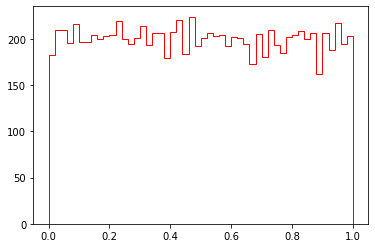

In [135]:
all_fidelities = []

thetas = np.linspace(0,2*np.pi,100)
for theta in thetas: 
    all_fidelities += approx_gate_fid(100,'rx',args1=[theta,0])

num_bins = 50
H, bins = np.histogram(all_fidelities, num_bins, (0.,1.))

plt.hist(all_fidelities, bins=num_bins, range=[0, 1], histtype='step',edgecolor='r')
plt.show()

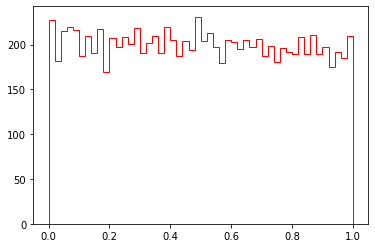

In [134]:
all_fidelities = []

thetas = np.linspace(0,2*np.pi,100)
for theta in thetas: 
    all_fidelities += approx_gate_fid(100,'x')

num_bins = 50
H, bins = np.histogram(all_fidelities, num_bins, (0.,1.))

plt.hist(all_fidelities, bins=num_bins, range=[0, 1], histtype='step',edgecolor='r')
plt.show()